Full testing/ training of 

LinearRegression, KNeighborsRegressor, and keras CNN

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
import numpy as np
from scipy.datasets import electrocardiogram
from scipy.signal import find_peaks, argrelmin, find_peaks_cwt
from collections import Counter
from scipy import signal
from pathlib import Path
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
import pickle
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D,ConvLSTM1D, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [19]:
# Run this to get started
path_aurora_dataset = Path('/Users/cslinxs/Desktop/aurora_dataset/aurora_dataset/')


dictionary_aurora_50_sampled_path = "measurements_auscultatory_dictionary_ALL.pkl"
auscultatory_data = path_aurora_dataset / "measurements_auscultatory.tsv"
participants_data =  path_aurora_dataset / "participants.tsv"


# Use pwdb_model_configs file
participants_dps_csv_data = pd.read_csv("/Users/cslinxs/Desktop/all_weeks/pwdb_model_configs.csv")




with open(dictionary_aurora_50_sampled_path, 'rb') as handle:
    all_auscultatory_dic = pickle.load(handle)


bad_keys = []
for key, each_grouping in all_auscultatory_dic.items():
    if True in list(np.isnan(each_grouping[0])):
        bad_keys.append(key)
print(bad_keys)

for key in bad_keys:
    del all_auscultatory_dic[key]




keys_for_grouping = [
"Calibration_start",
"Static_challenge_start",
"Seated_calibration",
"Static_seated_challenge",
"Exercise_challenge_start",
"Temporal_challenge_start",
"Temporal_seated_challenge"]

['measurements_auscultatory/a064/a064.initial.Static_seated_challenge_1.tsv', 'measurements_auscultatory/a150/a150.return.Temporal_challenge_start_3.tsv', 'measurements_auscultatory/a328/a328.initial.Exercise_challenge_start_1.tsv', 'measurements_auscultatory/a578/a578.initial.Static_challenge_start_1.tsv', 'measurements_auscultatory/a596/a596.initial.Exercise_challenge_start_1.tsv', 'measurements_auscultatory/a642/a642.initial.Exercise_challenge_start_1.tsv', 'measurements_auscultatory/a648/a648.initial.Seated_calibration_1.tsv', 'measurements_auscultatory/a437/a437.initial.Exercise_challenge_start_2.tsv', 'measurements_auscultatory/a437/a437.return.Temporal_seated_challenge_2.tsv']


In [41]:
#all functions
def get_stats(check_list):
    standard = float(np.std(check_list))
    mean = float(np.mean(check_list))
    return [min(check_list, default="EMPTY"),mean-standard-standard,mean-standard,mean,mean + standard,mean +standard+standard ,max(check_list) ]

def reject_outliers(data):
    return data[abs(data - np.mean(data)) <3 * np.std(data)]

def get_50_avg_coordinates(path):
    print(path)
    df = pd.read_csv(path,sep = '\t')   
    pos_pressure = df["pressure"]

    neglist = [ -x for x in pos_pressure]

    # ADD THE DROPPING DWOAN AND GETMIN BELLOW a LINE
    b, a = signal.butter(1, 0.002, analog=False)
    gustafsson_avg = signal.filtfilt(b, a, x= pos_pressure, method="gust")
    y_flater = [real_pre-abs( guston_avg) for real_pre, guston_avg in zip(pos_pressure, gustafsson_avg)]

    y_flater = np.array(y_flater)
    neglist = [ -x for x in y_flater]

    neg_max_values = max(neglist)
    neg_mix_values = min(neglist)
    mid_neg_value= neg_max_values - neg_mix_values

    min_height = neg_max_values - mid_neg_value*0.15 

    min_peaks, _ = find_peaks(neglist , height= min_height)

    
    most_accurate_mins = min_peaks
    diffrences_new_min = reject_outliers(np.diff(most_accurate_mins))

    mean_new_min = float(diffrences_new_min.mean())
    overlapped_means = pd.DataFrame( )

    nans_list = np.full(int(mean_new_min- get_stats(diffrences_new_min)[1]), np.nan)
    
    for i in range(len(most_accurate_mins)-1):
        
        current_pulse_width = int(most_accurate_mins[i+1]) -int(most_accurate_mins[i])
        if (current_pulse_width)< get_stats(diffrences_new_min)[4] and (current_pulse_width)> get_stats(diffrences_new_min)[1]:
            y_range  = list(range(int(most_accurate_mins[i]),int(most_accurate_mins[i+1])))
            y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]


            start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)
            y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]
            
            if len(y_rotated)>=int(mean_new_min):

                pulse_data_cut_short = pd.Series(list(y_rotated)[:int(mean_new_min)] )

                overlapped_means = pd.concat([overlapped_means, pulse_data_cut_short.rename(f"pulse {i}")], axis=1)
            else:
                
                pulse_data_and_Nan_filler = pd.Series(list(y_rotated)[:int(mean_new_min)] + list(nans_list[:int(mean_new_min) - len(y_rotated)]) )

                overlapped_means = pd.concat([overlapped_means, pulse_data_and_Nan_filler.rename(f"pulse {i}")], axis=1)

    overlapped_means['mean'] = overlapped_means.mean(axis=1)
    all_overlaps_means = (overlapped_means.mean(axis=1))
    resampled_y = signal.resample(all_overlaps_means, 50)
    return resampled_y



# Filter by activity
# Filters to activty's first file no overlap
def filter_by_activity(activity_number=1):
    if activity_number ==-1:
        auscultatory_pressure =[item[0] for item in all_auscultatory_dic.values()]
        auscultatory_sbp = [item[1] for item in all_auscultatory_dic.values()]
        auscultatory_dbp = [item[2] for item in all_auscultatory_dic.values()]
        return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 
    activity_tested_on = activity_number
    

    title_filtered_all_auscultatory_dic= dict(all_auscultatory_dic)
    for key, each_grouping in all_auscultatory_dic.items():
        if not(f"{keys_for_grouping[activity_tested_on]}_1" in  key):
            del title_filtered_all_auscultatory_dic[key]
    auscultatory_pressure =[item[0] for item in title_filtered_all_auscultatory_dic.values()]
    auscultatory_sbp = [item[1] for item in title_filtered_all_auscultatory_dic.values()]
    auscultatory_dbp = [item[2] for item in title_filtered_all_auscultatory_dic.values()]
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 

# Filters by systolic value
def filter_by_sbp(SBP_range = (120,120), activity_number=1):
    activity_tested_on = activity_number

    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp= filter_by_activity(activity_number)
    title_filtered_all_auscultatory_dic= dict(all_auscultatory_dic)
    for i in [sb for sb in range(len(auscultatory_sbp)) if (float(auscultatory_dbp[sb])<=SBP_range[0] and float(auscultatory_sbp[sb])>SBP_range[1]  ) ][::-1]:
        #print("hi")
        auscultatory_pressure.pop(i)
        auscultatory_sbp.pop(i)
        auscultatory_dbp.pop(i)
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 

# Filters by systolic value
def filter_by_dbp(DBP_range = (70,80), activity_number=1):
    activity_tested_on = activity_number

    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp= filter_by_activity(activity_number)
    title_filtered_all_auscultatory_dic= dict(all_auscultatory_dic)
    for i in [sb for sb in range(len(auscultatory_dbp)) if (float(auscultatory_dbp[sb])<=DBP_range[0] and float(auscultatory_dbp[sb])>DBP_range[1]  ) ][::-1]:
        #print("hi")
        auscultatory_pressure.pop(i)
        auscultatory_sbp.pop(i)
        auscultatory_dbp.pop(i)
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 


def filter_charlton_subjects():
    charlton_point_dbp = [[],[],[]]

    # will track age,dbp values
    charlton_set_seen_duplicates =set()

    Charlton_dataset_csv = "/Users/cslinxs/Desktop/all_weeks/Charlton_dataset_csv"
    for files in os.listdir(Charlton_dataset_csv):
        if "_P.Csv" in files.title() and "Digital" in files.title():
            body_part = files.title().split("_")[1]
            function = files.title().split("_")[2]
            participants_csv_data = pd.read_csv(Charlton_dataset_csv+"/"+files)
            
            for i in range(len(participants_csv_data)):
                y_points = participants_csv_data.iloc[i][1:].dropna()
                
                resampled_y = signal.resample(y_points, 50)
                resampled_y = [int(y - min(resampled_y)) for y in resampled_y]
                
                if not(True in list(np.isnan(resampled_y))):
                    indivuals_set = (participants_dps_csv_data.get(" age [years]")[i],participants_dps_csv_data.get(" dbp [mmHg]")[i],participants_dps_csv_data.get(" pvr [Pa s/m^3]")[i])
                    if not(indivuals_set in charlton_set_seen_duplicates):
                        charlton_point_dbp[0].append(resampled_y)
                        charlton_point_dbp[1].append(participants_dps_csv_data.get(" dbp [mmHg]")[i])
                        charlton_point_dbp[2].append(participants_dps_csv_data.get(" mbp [mmHg]")[i])
                        
                        charlton_set_seen_duplicates.add(indivuals_set)
    return charlton_point_dbp[0], charlton_point_dbp[1]

def LinearRegression_plot_MAE( activity_number=1):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)

    all_points = np.array(auscultatory_pressure)
    all_points = all_points.reshape(all_points.shape[0], -1)

    plt.figure(figsize=(5, 5)) 
    neigh = LinearRegression()


    X_train, X_test, Y_train, Y_test = train_test_split(all_points, auscultatory_dbp, test_size=0.3)




    the_fit= neigh.fit(X_train, Y_train)

    y_predict= neigh.predict(X_test)

    plt.rcParams.update({'font.size': 10})

    plt.plot(Y_test, Y_test, color="grey", linewidth=2, alpha=0.9)


    plt.scatter(Y_test, list(y_predict),  color="red",  alpha=0.5,s=50 )
    plt.title(f"LinearRegression Activity: {keys_for_grouping[activity_number]}")
    plt.xlabel("Tested DBP value")
    plt.ylabel("Predicted DBP value")

    xmin, xmax, ymin, ymax = plt.axis()
    plt.text(xmax+0.25, ymin+(ymax-ymin)*0.4,s=f"MAE {round(mean_absolute_error(Y_test, y_predict),2)}", fontsize=12)
    plt.text(xmax+0.25, ymin+(ymax-ymin)*0.2, s= f"RMS {round(root_mean_squared_error(Y_test, y_predict),2)}", fontsize=12)
    plt.text(xmax+0.25, ymin, s= f"r2 {round(r2_score(Y_test, y_predict),2)}", fontsize=12)
    plt.show()
    return round(mean_absolute_error(Y_test, y_predict),2)


def KNN_MAE_cross( activity_number=1, bp_variable = "s", n_neighbors=1, cross_valid_space = 50):
    
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp
    else: 
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)
        if bp_variable=="d":
            bp_variable_val = auscultatory_dbp
        elif bp_variable=="s":
            bp_variable_val = auscultatory_sbp

    all_mea = []

    for i in range(0,len(auscultatory_pressure),cross_valid_space): 

        X = auscultatory_pressure[0:i] + auscultatory_pressure[i+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:i] +bp_variable_val[i+cross_valid_space:len(auscultatory_pressure)])
        
        X_other = auscultatory_pressure[i:i+cross_valid_space] 
        Y_other = np.array(bp_variable_val[i:i+cross_valid_space])
        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)

        model = KNeighborsRegressor(n_neighbors=n_neighbors)

        X_test = X_test.reshape(X_test.shape[0], -1)

        the_fit = model.fit(X_train, Y_train)

        y_predict= model.predict(X_test)

        all_mea.append(round(mean_absolute_error(Y_test, y_predict),2))
        plt.rcParams.update({'font.size': 10})

    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

def LinearRegression_MAE_cross( activity_number=1, bp_variable = "s", cross_valid_space = 50):
    
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp
    else: 
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)
        if bp_variable=="d":
            bp_variable_val = auscultatory_dbp
        elif bp_variable=="s":
            bp_variable_val = auscultatory_sbp

    all_mea = []

    for i in range(0,len(auscultatory_pressure),cross_valid_space): 

        X = auscultatory_pressure[0:i] + auscultatory_pressure[i+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:i] +bp_variable_val[i+cross_valid_space:len(auscultatory_pressure)])
        
        X_other = auscultatory_pressure[i:i+cross_valid_space] 
        Y_other = np.array(bp_variable_val[i:i+cross_valid_space])
        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)

        model = LinearRegression()

        X_test = X_test.reshape(X_test.shape[0], -1)

        the_fit = model.fit(X_train, Y_train)

        y_predict= model.predict(X_test)

        all_mea.append(round(mean_absolute_error(Y_test, y_predict),2))
        plt.rcParams.update({'font.size': 10})

    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

                    

def CNN_MAE_cross( activity_number=1, bp_variable = "s", cross_valid_space = 50):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        # auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        # bp_variable_val = auscultatory_dbp
        print("Use [CNN_MAE_cross_charlton] method")
        return None
    else: 
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)
        if bp_variable=="d":
            bp_variable_val = auscultatory_dbp
        elif bp_variable=="s":
            bp_variable_val = auscultatory_sbp


    all_mea = []

    for i in range(0,len(auscultatory_pressure),cross_valid_space): 

        X = auscultatory_pressure[0:i] + auscultatory_pressure[i+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:i] +bp_variable_val[i+cross_valid_space:len(auscultatory_pressure)])
        
        X_other = auscultatory_pressure[i:i+cross_valid_space] 
        Y_other = np.array(bp_variable_val[i:i+cross_valid_space])
        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)

        def create_model():
            model = Sequential()
            model.add(Conv1D(filters=64, kernel_size=3,strides=3, activation='relu', input_shape=((X_train).shape[1], 1)))
            model.add(Dropout(0.5))
            model.add(Conv1D(256, kernel_size=3, strides=3, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Flatten())
            model.add(Dense(1))
            optimizer = RMSprop(0.001)
            model.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['mae',])
            return model
        model = create_model()
        history = model.fit(X_train, tf.stack(Y_train), epochs=50, validation_split=0.3)
        test_loss, test_accuracy = model.evaluate(X_test,tf.stack(Y_test) )


        all_mea.append(test_accuracy)
        

    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

def CNN_MAE_cross_charlton( activity_number=1, bp_variable = "s", cross_valid_space = 50):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp
    else: 
        print("Use [CNN_MAE_cross] method")
        return None


    all_mea = []
    cross_valid_space=50
    for i in range(0,len(auscultatory_pressure),50): 
        X = auscultatory_pressure[0:cross_valid_space] + auscultatory_pressure[cross_valid_space+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:cross_valid_space] +bp_variable_val[cross_valid_space+cross_valid_space:len(bp_variable_val)])
        
        X_other = auscultatory_pressure[cross_valid_space:cross_valid_space+50] 
        Y_other = np.array(bp_variable_val[cross_valid_space:cross_valid_space+50])

        
        X_test= np.array(X)
        Y_test= np.array(Y)
        
        X_train= np.array(X_other)
        Y_train= np.array(Y_other)



        def create_model():
            model = Sequential()
            model.add(Conv1D(filters=64, kernel_size=3,strides=3, activation='relu', input_shape=((X_train).shape[1], 1)))
            model.add(Dropout(0.5))
            model.add(Conv1D(256, kernel_size=3, strides=3, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Flatten())
            model.add(Dense(1))


            optimizer = RMSprop(0.001)

            model.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['mae',])

            return model
        model = create_model()
        
        history = model.fit(X_train, tf.stack(Y_train), epochs=50, validation_split=0.3)
        test_loss, test_accuracy = model.evaluate(X_test,tf.stack(Y_test) )


        all_mea.append(test_accuracy)
    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

        

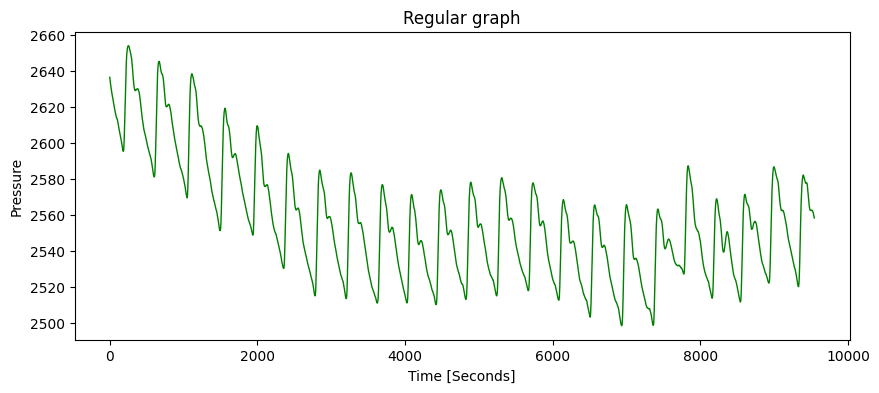

In [20]:
path = "/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a002/a002.initial.Static_seated_challenge_1.tsv"

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

plt.figure(figsize=(10, 4)) 
plt.rcParams.update({'font.size': 10})

plt.plot(pos_pressure,  linewidth=1, label='real', color= "green")

plt.title("Regular graph")
# plt.legend(loc='best')
plt.ylabel("Pressure")
plt.xlabel("Time [Seconds]")
plt.show()

In [ ]:
#path = "/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a004/a004.initial.Exercise_challenge_start_1.tsv"

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

plt.figure(figsize=(15, 4)) 
plt.rcParams.update({'font.size': 10})

plt.plot(pos_pressure,  linewidth=1, label='real', color= "purple")

plt.xticks([])
plt.yticks([])

plt.show()

In [ ]:
df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]


b, a = signal.butter(1, 0.002, analog=False)
gustafsson_avg = signal.filtfilt(b, a, x= pos_pressure, method="gust")
plt.plot(gustafsson_avg, 'b-', linewidth=2, label='gust',)
plt.plot(pos_pressure,  linewidth=1, label='real', color= "purple")

plt.title("with gustafsson_avg 0.002 frequency")
plt.legend(loc='best')
plt.ylabel("Pressure")
plt.xlabel("time (seconds)")
plt.show()

In [ ]:

# df = pd.read_csv(path,sep = '\t')   
# pos_pressure = df["pressure"]

y_flater = [real_pre-abs( guston_avg) for real_pre, guston_avg in zip(pos_pressure, gustafsson_avg)]

y_flater = np.array(y_flater)
neglist = [ -x for x in y_flater]

neg_max_values = max(neglist)
neg_mix_values = min(neglist)
mid_neg_value= neg_max_values - neg_mix_values

min_height = neg_max_values - mid_neg_value*0.15 

min_peaks, _ = find_peaks(neglist , height= min_height, width=50)


plt.plot(y_flater, color="red", linewidth=2)
plt.plot(min_peaks, y_flater[min_peaks], "x",)
plt.title("flattened minums with height 15%")
plt.show()


In [ ]:
most_accurate_mins = min_peaks
diffrences_new_min = reject_outliers(np.diff(most_accurate_mins))

mean_new_min = float(diffrences_new_min.mean())
overlapped_means = pd.DataFrame( )

nans_list = np.full(int(mean_new_min- get_stats(diffrences_new_min)[1]), np.nan)

In [ ]:
all_overlaps = [[] for i in range(int(max(diffrences_new_min)))]

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

newst_mins= np.asarray(list(most_accurate_mins), dtype=np.float32)

mini_list = list(newst_mins)

for i in range(len(mini_list)-1):

    if (int(mini_list[i+1]) -int(mini_list[i]))< get_stats(diffrences_new_min)[4] :
        y_range  = list(range(int(mini_list[i]),int(mini_list[i+1])))
        y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]
 
        x_range = list(range(int(mini_list[i]),int(mini_list[i+1])))
        x_of_shift = [int(x - x_range[0]) for x in x_range]
        start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)

        y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]


        for x_indi in range(len(x_range)):
            all_overlaps[x_indi].append(int(y_of_shift[x_indi]-start_end_line[x_indi]))

        plt.plot(y_of_shift, color="red")
        plt.plot(start_end_line,color="grey" , alpha=0.9)


plt.title("Overlapping Pulses")
plt.ylabel("Pressure")
plt.xlabel("time (seconds)")
plt.xticks([])
plt.yticks([])

plt.show()

In [ ]:
all_overlaps = [[] for i in range(int(max(diffrences_new_min)))]

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

newst_mins= np.asarray(list(most_accurate_mins), dtype=np.float32)

mini_list = list(newst_mins)

for i in range(len(mini_list)-1):

    if (int(mini_list[i+1]) -int(mini_list[i]))< get_stats(diffrences_new_min)[4] :
        y_range  = list(range(int(mini_list[i]),int(mini_list[i+1])))
        y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]
 
        x_range = list(range(int(mini_list[i]),int(mini_list[i+1])))
        x_of_shift = [int(x - x_range[0]) for x in x_range]
        start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)

        y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]


        for x_indi in range(len(x_range)):
            all_overlaps[x_indi].append(int(y_of_shift[x_indi]-start_end_line[x_indi]))

        plt.plot(y_rotated, color="red")


plt.title("Overlapping Pulses translated to x axis")
plt.ylabel("Pressure")
plt.xlabel("Time [seconds]")

plt.show()

In [ ]:
#to get data for the overall mean 
all_overlaps_means = []
#mean for each row
for lists in all_overlaps:
    all_overlaps_means.append(np.mean(lists))

all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']
plt.plot(all_overlaps_means, color='red')
plt.title("Average pulse in 1 activity")
plt.ylabel("Pressure")
plt.xlabel("Time [seconds]")
contecting_it = np.linspace(all_overlaps_means[0], all_overlaps_means[-1], len(all_overlaps_means), endpoint=True)
plt.show()
all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']


In [ ]:
#to get data for the overall mean 
all_overlaps_means = []
#mean for each row
for lists in all_overlaps:
    all_overlaps_means.append(np.mean(lists))

all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']

resampled_y = signal.resample(all_overlaps_means, 50)
resampled_x = signal.resample(list(range(len(all_overlaps_means))), 50)


plt.plot(resampled_x,resampled_y,  'ro' )
plt.plot(all_overlaps_means )

plt.title("average based on all rates")
plt.ylabel("Pressure")
plt.xlabel("time seconds")

plt.show()

Demos are done.


Training Models:

Making the chart for aurora

In [ ]:

# LinearRegression_MAE_cross(-1, "s",1000)

# KNN_MAE_cross(-1, "s",1000)

# CNN_MAE_cross(-1, "s",1000)

# #or Run no overlap in participants , 0=Calibration_start recordings

# LinearRegression_MAE_cross(0, "s",50)

# KNN_MAE_cross(0, "s",50)

# CNN_MAE_cross(0, "s",50)



Done with Auroa and Charlton

Now I want to makethe graph chart

In [ ]:
LinearRegression_MAE_cross(-1, "c",10)


In [ ]:
KNN_MAE_cross(-1, "c",10)

In [ ]:
CNN_MAE_cross_charlton(-1, "c",10)


In [30]:
all_models = {}
for i in range(len(keys_for_grouping)):
    all_models[keys_for_grouping[i]]= []
all_models

{'Calibration_start': [],
 'Static_challenge_start': [],
 'Seated_calibration': [],
 'Static_seated_challenge': [],
 'Exercise_challenge_start': [],
 'Temporal_challenge_start': [],
 'Temporal_seated_challenge': []}

In [42]:
all_models = {}

for i in range(len(keys_for_grouping)):
    all_models[keys_for_grouping[i]]= [LinearRegression_MAE_cross(i, "s",50),KNN_MAE_cross(i, "s",50) , CNN_MAE_cross(i, "s",10)]





Epoch 1/50


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6801.4385 - mae: 71.4113 - val_loss: 3834.2407 - val_mae: 52.7751
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4025.5664 - mae: 52.2544 - val_loss: 3511.0703 - val_mae: 50.1539
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3886.7307 - mae: 50.2720 - val_loss: 4322.2065 - val_mae: 56.7705
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3762.8552 - mae: 51.9490 - val_loss: 3412.6738 - val_mae: 49.4557
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3946.5432 - mae: 51.7466 - val_loss: 3416.6790 - val_mae: 49.3489
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3740.9485 - mae: 49.4418 - val_loss: 3525.9277 - val_mae: 50.3771
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3721.7939 - mae: 50.0792 - val_loss: 3614.4458 - val_mae: 50.9738
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3798.7878 - mae: 51.1316 - val_loss: 3603.5212 - val_mae: 50.8751
Epoch 9/50
15/15 ━━

/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8074.1450 - mae: 76.4014 - val_loss: 4617.7041 - val_mae: 58.4363
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3832.7004 - mae: 51.3553 - val_loss: 3964.8943 - val_mae: 53.5533
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3488.7131 - mae: 47.7835 - val_loss: 3810.5071 - val_mae: 52.3630
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3907.3308 - mae: 51.0255 - val_loss: 5183.9312 - val_mae: 63.1084
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3862.1455 - mae: 52.0078 - val_loss: 3980.5212 - val_mae: 53.5461
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3663.7231 - mae: 49.4870 - val_loss: 4320.9331 - val_mae: 56.4141
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3779.1221 - mae: 51.5452 - val_loss: 4362.5269 - val_mae: 56.8666
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3606.6438 - mae: 49.0489 - val_loss: 4585.0991 - val_mae: 58.7429
Epoch 9/50
15/15 ━

/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9488.3896 - mae: 87.2746 - val_loss: 4011.7510 - val_mae: 52.1990
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3509.5398 - mae: 49.0298 - val_loss: 4109.1426 - val_mae: 53.5351
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4129.2744 - mae: 54.4690 - val_loss: 4019.0051 - val_mae: 52.6387
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4246.7969 - mae: 54.8522 - val_loss: 3897.6052 - val_mae: 51.2544
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4701.8784 - mae: 55.8862 - val_loss: 3842.0569 - val_mae: 50.7098
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4098.4761 - mae: 52.4331 - val_loss: 3827.4783 - val_mae: 50.6771
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3614.1677 - mae: 49.4260 - val_loss: 3811.8235 - val_mae: 50.6126
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3626.1875 - mae: 49.3569 - val_loss: 3823.1147 - val_mae: 50.9937
Epoch 9/50
10/10 ━

/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7248.0591 - mae: 75.5898 - val_loss: 3983.5854 - val_mae: 51.4721
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3881.3320 - mae: 52.2088 - val_loss: 3854.6714 - val_mae: 50.2902
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3836.6279 - mae: 52.0647 - val_loss: 3978.4668 - val_mae: 51.2481
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4268.1743 - mae: 56.7521 - val_loss: 3859.1831 - val_mae: 50.1425
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3804.4758 - mae: 51.7648 - val_loss: 3788.4114 - val_mae: 49.7445
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4015.9041 - mae: 53.2362 - val_loss: 3810.6650 - val_mae: 49.7964
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4033.6274 - mae: 53.7089 - val_loss: 3773.9846 - val_mae: 49.5719
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3848.3870 - mae: 52.0750 - val_loss: 3948.8821 - val_mae: 50.6140
Epoch 9/50
11/11 ━━

/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 12450.3486 - mae: 98.9725 - val_loss: 9195.3398 - val_mae: 78.4082
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7344.3618 - mae: 69.5143 - val_loss: 8447.5781 - val_mae: 77.4369
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7037.5645 - mae: 69.0246 - val_loss: 8899.4531 - val_mae: 76.8494
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7156.8120 - mae: 69.2594 - val_loss: 8464.8086 - val_mae: 76.5074
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6589.8921 - mae: 66.7347 - val_loss: 9113.5107 - val_mae: 75.8639
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7436.9414 - mae: 70.2569 - val_loss: 8400.5059 - val_mae: 76.1420
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6817.6797 - mae: 67.7961 - val_loss: 8366.0264 - val_mae: 75.7400
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6563.6797 - mae: 66.4857 - val_loss: 8989.2305 - val_mae: 74.5327
Epoch 9/50
15/15 

2024-08-02 09:42:53.591245: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0] vs. [1,16,64]
	 [[{{function_node __inference_one_step_on_data_3712363}}{{node sequential_581_1/conv1d_1162_1/add}}]]


InvalidArgumentError: Graph execution error:

Detected at node sequential_581_1/conv1d_1162_1/add defined at (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 596, in run_forever

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_8665/1652741465.py", line 4, in <module>

  File "/var/folders/hp/g2knsnlj4y18ybnh9bjz7rkh0000gp/T/ipykernel_8665/4056842082.py", line 330, in CNN_MAE_cross

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/models/sequential.py", line 209, in call

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py", line 175, in call

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py", line 556, in call

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/conv1d.py", line 166, in call

Incompatible shapes: [0] vs. [1,16,64]
	 [[{{node sequential_581_1/conv1d_1162_1/add}}]] [Op:__inference_one_step_on_iterator_3712408]

In [43]:
all_models

{'Calibration_start': [[14.330714285714285, 1.3503357481208376],
  [14.381428571428573, 1.9643786990978551],
  [19.60613707642057, 7.642453114018689]],
 'Static_challenge_start': [[14.60142857142857, 1.346444296990395],
  [14.715, 1.4636780969286143],
  [18.560070194415193, 6.14872169875062]],
 'Seated_calibration': [[15.743333333333332, 1.4373123065870779],
  [15.41111111111111, 1.031379275473645],
  [22.047927051120332, 8.573491184630697]],
 'Static_seated_challenge': [[16.494999999999997, 2.5126848190730158],
  [15.431999999999999, 2.2092478358029446],
  [24.11524353424708, 10.072488362678175]]}

In [35]:
all_models

{'Calibration_start': [[14.330714285714285, 1.3503357481208376],
  [14.381428571428573, 1.9643786990978551]],
 'Static_challenge_start': [[14.60142857142857, 1.346444296990395],
  [14.715, 1.4636780969286143]],
 'Seated_calibration': [[15.743333333333332, 1.4373123065870779],
  [15.41111111111111, 1.031379275473645]],
 'Static_seated_challenge': [[16.494999999999997, 2.5126848190730158],
  [15.431999999999999, 2.2092478358029446]],
 'Exercise_challenge_start': [[25.395000000000003, 3.847135762021999],
  [22.301428571428573, 4.640706314995683]],
 'Temporal_challenge_start': [[14.605714285714285, 2.027548534862852],
  [14.276428571428571, 1.8527069274938412]],
 'Temporal_seated_challenge': [[15.784444444444444, 1.640888046225859],
  [14.600000000000001, 1.6021235907382412]]}

In [37]:
all_models

{'Calibration_start': [[9.784285714285716, 1.0207820131484233],
  [9.727142857142857, 1.2193524544459091]],
 'Static_challenge_start': [[9.980714285714287, 1.2532384580170923],
  [9.824285714285717, 1.4540078319975454]],
 'Seated_calibration': [[9.55888888888889, 0.7618755285397043],
  [9.465555555555556, 1.2543888384487047]],
 'Static_seated_challenge': [[10.217, 1.463441491826714],
  [10.041, 1.5973318377844983]],
 'Exercise_challenge_start': [[16.393571428571427, 5.745658742716547],
  [13.963571428571429, 2.0492842204844433]],
 'Temporal_challenge_start': [[9.940000000000001, 1.3169173962597007],
  [9.847142857142858, 1.1113018657118747]],
 'Temporal_seated_challenge': [[10.02, 1.7128144480162852],
  [9.81111111111111, 1.3806475489135472]]}

In [84]:
      

def CNN_MAE_cross( activity_number=1, bp_variable = "s", cross_valid_space = 50):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        # auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        # bp_variable_val = auscultatory_dbp
        print("Use [CNN_MAE_cross_charlton] method")
        return None
    else: 
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)
        if bp_variable=="d":
            bp_variable_val = auscultatory_dbp
        elif bp_variable=="s":
            bp_variable_val = auscultatory_sbp


    all_mea = []

    for i in range(0,len(auscultatory_pressure),cross_valid_space): 

        X = auscultatory_pressure[0:i] + auscultatory_pressure[i+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:i] +bp_variable_val[i+cross_valid_space:len(auscultatory_pressure)])
        
        X_other = auscultatory_pressure[i:i+cross_valid_space] 
        Y_other = np.array(bp_variable_val[i:i+cross_valid_space])
        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)

        def create_model():
            model = Sequential()
            model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
            model.add(Dropout(0.5))
            model.add(Conv1D(32, 2, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Conv1D(64, 2, activation='relu'))
            model.add(Flatten())
            model.add(Dense(1))
            # model.add(Conv1D(64, 3, activation='relu'))
            # model.add(Dropout(0.5))

            # model.add(MaxPooling1D(pool_size=4, strides=1))
            # model.add(Conv1D(128, 3, activation='relu'))
            # model.add(Dropout(0.5))
            

            model.add(Flatten())
            model.add(Dense(1))
            # model.add(Conv1D(128, kernel_size=3, activation='relu',  input_shape=(X_train.shape[1], 1)))
            # model.add(Conv1D(1, kernel_size=5, activation='relu', ))
            optimizer = RMSprop(0.001)
            model.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['mae',])
            return model
        model = create_model()
        history = model.fit(X_train, tf.stack(Y_train), epochs=50, validation_split=0.3)
        test_loss, test_accuracy = model.evaluate(X_test,tf.stack(Y_test) )


        all_mea.append(test_accuracy)
        

    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]


In [85]:
CNN_MAE_cross(1, "s",50)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7879.7480 - mae: 72.7833 - val_loss: 6325.2539 - val_mae: 72.5839
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4085.4963 - mae: 53.3701 - val_loss: 8109.2812 - val_mae: 85.6150
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3853.7495 - mae: 51.3659 - val_loss: 9339.3145 - val_mae: 93.3754
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3679.6609 - mae: 49.9555 - val_loss: 6168.2041 - val_mae: 71.5293
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3442.3157 - mae: 48.8548 - val_loss: 6800.9277 - val_mae: 76.5862
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4104.6934 - mae: 53.0807 - val_loss: 7307.1445 - val_mae: 80.3628
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3677.1326 - mae: 49.9318 - val_loss: 8129.9141 - val_mae: 86.0154
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3700.3982 - mae: 49.0657 - val_loss: 8399.3037 - val_mae: 87.8330
Epoch 9/

[22.048490592411586, 8.917517433016233]

In [83]:
CNN_MAE_cross(0, "s",10)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8280.7725 - mae: 81.7736 - val_loss: 3927.1396 - val_mae: 53.7652
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3860.5347 - mae: 51.3598 - val_loss: 3470.7705 - val_mae: 49.7866
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4194.5786 - mae: 52.8481 - val_loss: 3641.1194 - val_mae: 51.3933
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3845.1492 - mae: 52.2653 - val_loss: 3492.2468 - val_mae: 50.2890
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3489.1899 - mae: 49.1071 - val_loss: 3643.2263 - val_mae: 51.3901
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3679.5137 - mae: 49.9857 - val_loss: 3320.6865 - val_mae: 48.9177
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3787.0996 - mae: 50.8783 - val_loss: 3384.0237 - val_mae: 49.0339
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3780.7947 - mae: 49.9807 - val_loss: 3285.0076 - val_mae: 48.6532
Epoch 9/

[23.377250600216993, 7.839989169326717]

In [61]:
CNN_MAE_cross(2, "s",50)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7492.4043 - mae: 74.9389 - val_loss: 7778.8677 - val_mae: 82.8817
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4537.2749 - mae: 54.6350 - val_loss: 6310.3770 - val_mae: 72.3026
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4199.3945 - mae: 53.7831 - val_loss: 4408.3906 - val_mae: 56.4657
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3909.0039 - mae: 51.2437 - val_loss: 9468.1084 - val_mae: 94.0406
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4024.9539 - mae: 52.9015 - val_loss: 6542.6147 - val_mae: 74.2718
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4666.1724 - mae: 56.3622 - val_loss: 8973.5176 - val_mae: 91.1881
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3969.8167 - mae: 53.0213 - val_loss: 8011.5562 - val_mae: 85.0355
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4060.1047 - mae: 52.3679 - val_loss: 11407.9160 - val_mae: 104.6559
Epoch 9/50
9/9 ━━━━━━

[39.90490468343099, 18.312127229299442]

In [ ]:
CNN_MAE_cross(0, "s",50)


In [90]:
# https://github.com/Sakib1263/VGG-1D-2D-Tensorflow-Keras/blob/main/Codes/VGG_1DCNN_Implementation_DEMO.ipynb

# VGG 1D-Convolution Architecture in Keras - For both Classification and Regression Problems
"""Reference: [Very Deep Convolutional Networks for Large-Scale Image Recognition] (https://arxiv.org/abs/1409.1556)"""


import tensorflow as tf


def Conv_1D_Block(x, model_width, kernel):
    # 1D Convolutional Block with BatchNormalization
    x = tf.keras.layers.Conv1D(model_width, kernel, padding='same', kernel_initializer="he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x


class VGG:
    def __init__(self, length, num_channel, num_filters, problem_type='Regression', output_nums=1, dropout_rate=False):
        self.length = length
        self.num_channel = num_channel
        self.num_filters = num_filters
        self.problem_type = problem_type
        self.output_nums = output_nums
        self.dropout_rate = dropout_rate

    def VGG11(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # The input tensor
        # Block 1
        x = Conv_1D_Block(inputs, self.num_filters * (2 ** 0), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 2
        x = Conv_1D_Block(x, self.num_filters * (2 ** 1), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 3
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 4
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 5
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Fully Connected (MLP) block
        x = tf.keras.layers.Flatten(name='flatten')(x)
        x = tf.keras.layers.Dense(4096, activation='relu')(x)
        x = tf.keras.layers.Dense(4096, activation='relu')(x)
        if self.dropout_rate:
            x = tf.keras.layers.Dropout(self.dropout_rate, name='Dropout')(x)
        outputs = tf.keras.layers.Dense(self.output_nums, activation='linear')(x)
        if self.problem_type == 'Classification':
            outputs = tf.keras.layers.Dense(self.output_nums, activation='softmax')(x)

        # Create model.
        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        return model

    def VGG13(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # The input tensor
        # Block 1
        x = Conv_1D_Block(inputs, self.num_filters * (2 ** 0), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 0), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 2
        x = Conv_1D_Block(x, self.num_filters * (2 ** 1), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 1), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 3
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 4
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 5
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Fully Connected (MLP) block
        x = tf.keras.layers.Flatten(name='flatten')(x)
        x = tf.keras.layers.Dense(4096, activation='relu')(x)
        x = tf.keras.layers.Dense(4096, activation='relu')(x)
        if self.dropout_rate:
            x = tf.keras.layers.Dropout(self.dropout_rate, name='Dropout')(x)
        outputs = tf.keras.layers.Dense(self.output_nums, activation='linear')(x)
        if self.problem_type == 'Classification':
            outputs = tf.keras.layers.Dense(self.output_nums, activation='softmax')(x)

        # Create model.
        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        return model

    def VGG16(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # The input tensor
        # Block 1
        x = Conv_1D_Block(inputs, self.num_filters * (2 ** 0), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 0), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 2
        x = Conv_1D_Block(x, self.num_filters * (2 ** 1), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 1), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 3
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 4
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 5
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Fully Connected (MLP) block
        x = tf.keras.layers.Flatten(name='flatten')(x)
        x = tf.keras.layers.Dense(4096, activation='relu')(x)
        x = tf.keras.layers.Dense(4096, activation='relu')(x)
        if self.dropout_rate:
            x = tf.keras.layers.Dropout(self.dropout_rate, name='Dropout')(x)
        outputs = tf.keras.layers.Dense(self.output_nums, activation='linear')(x)
        if self.problem_type == 'Classification':
            outputs = tf.keras.layers.Dense(self.output_nums, activation='softmax')(x)

        # Create model.
        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        return model

    def VGG16_v2(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # The input tensor
        # Block 1
        x = Conv_1D_Block(inputs, self.num_filters * (2 ** 0), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 0), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 2
        x = Conv_1D_Block(x, self.num_filters * (2 ** 1), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 1), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 3
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 1)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 4
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 1)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 5
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 1)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Fully Connected (MLP) block
        x = tf.keras.layers.Flatten(name='flatten')(x)
        x = tf.keras.layers.Dense(4096, activation='relu')(x)
        x = tf.keras.layers.Dense(4096, activation='relu')(x)
        if self.dropout_rate:
            x = tf.keras.layers.Dropout(self.dropout_rate, name='Dropout')(x)
        outputs = tf.keras.layers.Dense(self.output_nums, activation='linear')(x)
        if self.problem_type == 'Classification':
            outputs = tf.keras.layers.Dense(self.output_nums, activation='softmax')(x)

        # Create model.
        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        return model

    def VGG19(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # The input tensor
        # Block 1
        x = Conv_1D_Block(inputs, self.num_filters * (2 ** 0), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 0), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 2
        x = Conv_1D_Block(x, self.num_filters * (2 ** 1), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 1), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 3
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 4
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 5
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Fully Connected (MLP) block
        x = tf.keras.layers.Flatten(name='flatten')(x)
        x = tf.keras.layers.Dense(4096, activation='relu')(x)
        x = tf.keras.layers.Dense(4096, activation='relu')(x)
        if self.dropout_rate:
            x = tf.keras.layers.Dropout(self.dropout_rate, name='Dropout')(x)
        outputs = tf.keras.layers.Dense(self.output_nums, activation='linear')(x)
        if self.problem_type == 'Classification':
            outputs = tf.keras.layers.Dense(self.output_nums, activation='softmax')(x)

        # Create model.
        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        return model


if __name__ == '__main__':
    # Configurations
    length = 50  # Length of each Segment
    model_name = 'VGG19'  # DenseNet Models
    model_width = 1 # Width of the Initial Layer, subsequent layers start from here
    num_channel = 1  # Number of Input Channels in the Model
    problem_type = 'Regression' # Classification or Regression
    output_nums = 1  # Number of Class for Classification Problems, always '1' for Regression Problems
    #
    Model = VGG(length, num_channel, model_width, problem_type=problem_type, output_nums=output_nums, dropout_rate=False).VGG19()
    #Model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss=tf.keras.losses.MeanAbsoluteError(), metrics=tf.keras.metrics.MeanSquaredError())
    Model.compile(loss='mae', optimizer='adam', metrics= ['mse'])
    
    Model.summary()
    history = Model.fit(X_Train, Y_Train, epochs=500, batch_size=128, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)


Model: "functional_5428"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_875 (InputLayer)    │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1925 (Conv1D)            │ (None, 50, 1)          │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 50, 1)          │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_64 (Activation)      │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1926 (Conv1D)            │ (None, 50, 1)          │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 50, 1)          │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_65 (Activation)      │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_62 (MaxPooling1D) │ (None, 25, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1927 (Conv1D)            │ (None, 25, 2)          │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 25, 2)          │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_66 (Activation)      │ (None, 25, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1928 (Conv1D)            │ (None, 25, 2)          │            14 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 25, 2)          │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_67 (Activation)      │ (None, 25, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_63 (MaxPooling1D) │ (None, 12, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1929 (Conv1D)            │ (None, 12, 4)          │            28 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 12, 4)          │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_68 (Activation)      │ (None, 12, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1930 (Conv1D)            │ (None, 12, 4)          │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 12, 4)          │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_69 (Activation)      │ (None, 12, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1931 (Conv1D)            │ (None, 12, 4)          │            5

 Total params: 16,824,335 (64.18 MB)

 Trainable params: 16,824,163 (64.18 MB)

 Non-trainable params: 172 (688.00 B)

In [96]:
      

def CNN_MAE_cross( activity_number=1, bp_variable = "s", cross_valid_space = 50):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        # auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        # bp_variable_val = auscultatory_dbp
        print("Use [CNN_MAE_cross_charlton] method")
        return None
    else: 
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)
        if bp_variable=="d":
            bp_variable_val = auscultatory_dbp
        elif bp_variable=="s":
            bp_variable_val = auscultatory_sbp


    all_mea = []

    for i in range(0,len(auscultatory_pressure),cross_valid_space): 

        X = auscultatory_pressure[0:i] + auscultatory_pressure[i+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:i] +bp_variable_val[i+cross_valid_space:len(auscultatory_pressure)])
        
        X_other = auscultatory_pressure[i:i+cross_valid_space] 
        Y_other = np.array(bp_variable_val[i:i+cross_valid_space])
        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)



        length = 50  # Length of each Segment
        model_name = 'VGG19'  # DenseNet Models
        model_width = 1 # Width of the Initial Layer, subsequent layers start from here
        num_channel = 1  # Number of Input Channels in the Model
        problem_type = 'Regression' # Classification or Regression
        output_nums = 1  # Number of Class for Classification Problems, always '1' for Regression Problems
        #
        Model = VGG(length, num_channel, model_width, problem_type=problem_type, output_nums=output_nums, dropout_rate=False).VGG19()
        #Model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss=tf.keras.losses.MeanAbsoluteError(), metrics=tf.keras.metrics.MeanSquaredError())
        Model.compile(loss='mae', optimizer='adam', metrics= ['mse'])
        
        Model.summary()
        #history = Model.fit(X_train, Y_train, epochs=500, batch_size=128, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)

        history = Model.fit(X_train, tf.stack(Y_train), epochs=50, validation_split=0.3)
        test_loss, test_accuracy = model.evaluate(X_test,tf.stack(Y_test) )


        all_mea.append(test_accuracy)
        

    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]


In [97]:
CNN_MAE_cross(0, "s",50)


Model: "functional_5431"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_878 (InputLayer)    │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1973 (Conv1D)            │ (None, 50, 1)          │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_112         │ (None, 50, 1)          │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_112 (Activation)     │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1974 (Conv1D)            │ (None, 50, 1)          │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_113         │ (None, 50, 1)          │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_113 (Activation)     │ (None, 50, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_77 (MaxPooling1D) │ (None, 25, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1975 (Conv1D)            │ (None, 25, 2)          │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 25, 2)          │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_114 (Activation)     │ (None, 25, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1976 (Conv1D)            │ (None, 25, 2)          │            14 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_115         │ (None, 25, 2)          │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_115 (Activation)     │ (None, 25, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_78 (MaxPooling1D) │ (None, 12, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1977 (Conv1D)            │ (None, 12, 4)          │            28 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_116         │ (None, 12, 4)          │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_116 (Activation)     │ (None, 12, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1978 (Conv1D)            │ (None, 12, 4)          │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_117         │ (None, 12, 4)          │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_117 (Activation)     │ (None, 12, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1979 (Conv1D)            │ (None, 12, 4)          │            5

 Total params: 16,824,335 (64.18 MB)

 Trainable params: 16,824,163 (64.18 MB)

 Non-trainable params: 172 (688.00 B)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 108.5811 - mse: 13064.2666 - val_loss: 94.8696 - val_mse: 9278.0732
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 36.1016 - mse: 2278.8804 - val_loss: 86.2580 - val_mse: 7728.8340
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 29.6795 - mse: 1325.5210 - val_loss: 72.2921 - val_mse: 5517.3999
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 19.7954 - mse: 644.9566 - val_loss: 57.5863 - val_mse: 3600.6653
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 19.2208 - mse: 588.2319 - val_loss: 44.9970 - val_mse: 2301.6116
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 16.5156 - mse: 457.5792 - val_loss: 46.0436 - val_mse: 2402.2810
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 17.5023 - mse: 482.4598 - val_loss: 36.2560 - val_mse: 1606.5204
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 16.3671 - mse: 435.8726 - val_loss: 31.1755 - val_mse: 1266.1229
Epo

NameError: name 'model' is not defined